In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchquantum as tq

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2

from skimage import io
from PIL import Image


In [2]:
# define controlled hadamard gate
sq2 = 1/np.sqrt(2)
def controlled_H(qdev, target,control):
      qdev.apply(tq.QubitUnitary(
      has_params=True,init_params=([[1,0,0,0],[0,sq2,0,sq2],[0,0,1,0],[0,sq2,0,-sq2]]),wires=[target,control]))
 

In [3]:
# x is the input 
x = torch.tensor([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
x = torch.rand(100,256,256)

print(x.shape)
#x = x.view(4,16) # to reshape the tensor
print(x[0])

torch.Size([100, 256, 256])
tensor([[0.3030, 0.2007, 0.6386,  ..., 0.5254, 0.4999, 0.7646],
        [0.7480, 0.5043, 0.0289,  ..., 0.2556, 0.1037, 0.9940],
        [0.9423, 0.8519, 0.6105,  ..., 0.0131, 0.7863, 0.3474],
        ...,
        [0.6167, 0.6138, 0.9739,  ..., 0.5303, 0.0064, 0.4724],
        [0.7078, 0.7094, 0.3499,  ..., 0.7939, 0.8849, 0.3362],
        [0.6720, 0.8666, 0.0578,  ..., 0.2555, 0.1392, 0.1099]])


In [4]:
print(x[2])

tensor([[0.7784, 0.5591, 0.3961,  ..., 0.5004, 0.2016, 0.5975],
        [0.9733, 0.1010, 0.6600,  ..., 0.4577, 0.1310, 0.8191],
        [0.6658, 0.6713, 0.0565,  ..., 0.6084, 0.0792, 0.8762],
        ...,
        [0.5066, 0.6376, 0.8987,  ..., 0.2790, 0.5698, 0.0925],
        [0.3942, 0.0555, 0.9460,  ..., 0.3508, 0.6309, 0.7568],
        [0.5540, 0.1183, 0.7902,  ..., 0.7451, 0.3916, 0.4057]])


In [5]:
#print(x[0]) # first image
#print(x[0,0]) # first row of the first image
print(x[0,0,0]) # first pixel of the first row of the first image
#print(x[0,:,0]) # first column of the first image
print(x[:,0,0]) # list of pixels at (0,0) of all images
x[:,0,0+1] # list of pixels at (0,1) of all images
x[:,0+1,0] # list of pixels at (1,0) of all images
x[:,0+1,0+1] # list of pixels at (1,1) of all images
torch.cat((x[:, 0, 0], x[:, 0, 0+1], x[:, 0+1, 0], x[:, 0+1, 0+1])) # list of pixels at (0,0), (0,1), (1,0), (1,1) of all images

tensor(0.3030)
tensor([0.3030, 0.8216, 0.7784, 0.8255, 0.3225, 0.0501, 0.0227, 0.6734, 0.5168,
        0.8862, 0.8110, 0.1986, 0.0096, 0.8365, 0.9510, 0.2922, 0.2806, 0.4032,
        0.9098, 0.1340, 0.9125, 0.9570, 0.9547, 0.6860, 0.5312, 0.5451, 0.9063,
        0.2277, 0.7242, 0.2566, 0.4647, 0.1871, 0.4912, 0.5283, 0.6460, 0.6434,
        0.7861, 0.7043, 0.3678, 0.4620, 0.7473, 0.4417, 0.0829, 0.8616, 0.3907,
        0.1528, 0.7070, 0.9098, 0.2848, 0.7458, 0.8264, 0.6728, 0.8079, 0.5105,
        0.8518, 0.6630, 0.1570, 0.0988, 0.5357, 0.8332, 0.8755, 0.6563, 0.1426,
        0.3272, 0.0859, 0.7197, 0.2992, 0.7897, 0.4268, 0.6672, 0.7740, 0.1976,
        0.3226, 0.2511, 0.1034, 0.9297, 0.5082, 0.8003, 0.2424, 0.5414, 0.0561,
        0.3517, 0.8830, 0.7155, 0.8899, 0.6552, 0.0444, 0.7776, 0.5495, 0.8729,
        0.0116, 0.7036, 0.9162, 0.6167, 0.6498, 0.1397, 0.7119, 0.3944, 0.3879,
        0.6555])


tensor([0.3030, 0.8216, 0.7784, 0.8255, 0.3225, 0.0501, 0.0227, 0.6734, 0.5168,
        0.8862, 0.8110, 0.1986, 0.0096, 0.8365, 0.9510, 0.2922, 0.2806, 0.4032,
        0.9098, 0.1340, 0.9125, 0.9570, 0.9547, 0.6860, 0.5312, 0.5451, 0.9063,
        0.2277, 0.7242, 0.2566, 0.4647, 0.1871, 0.4912, 0.5283, 0.6460, 0.6434,
        0.7861, 0.7043, 0.3678, 0.4620, 0.7473, 0.4417, 0.0829, 0.8616, 0.3907,
        0.1528, 0.7070, 0.9098, 0.2848, 0.7458, 0.8264, 0.6728, 0.8079, 0.5105,
        0.8518, 0.6630, 0.1570, 0.0988, 0.5357, 0.8332, 0.8755, 0.6563, 0.1426,
        0.3272, 0.0859, 0.7197, 0.2992, 0.7897, 0.4268, 0.6672, 0.7740, 0.1976,
        0.3226, 0.2511, 0.1034, 0.9297, 0.5082, 0.8003, 0.2424, 0.5414, 0.0561,
        0.3517, 0.8830, 0.7155, 0.8899, 0.6552, 0.0444, 0.7776, 0.5495, 0.8729,
        0.0116, 0.7036, 0.9162, 0.6167, 0.6498, 0.1397, 0.7119, 0.3944, 0.3879,
        0.6555, 0.2007, 1.0000, 0.5591, 0.7183, 0.4605, 0.9237, 0.4281, 0.7913,
        0.9628, 0.8467, 0.5816, 0.9804, 

In [6]:
x1 = torch.cat((x[:, 0, 0], x[:, 0, 0+1], x[:, 0+1, 0], x[:, 0+1, 0+1])).view(4, 100) # first matrix/list is the list of all pixels at (0,0). second matrix/list is the list of all pixels at (0,1). third matrix/list is the list of all pixels at (1,0). fourth matrix/list is the list of all pixels at (1,1). 


In [7]:
x1 = torch.transpose(torch.cat((x[:, 0, 0], x[:, 0, 0+1], x[:, 0+1, 0], x[:, 0+1, 0+1])).view(4, 100),0,1) # first row contains (0,0)(0,1)(1,0)(1,1) pixels


In [8]:
bsz = x.shape[0] # batch size
size = 256 # height and width of an image
x = x.view(bsz, size, size) # reshape the data 

data_list = []

for c in range(0, size, 2):
    for r in range(0, size, 2):
        data = torch.transpose(torch.cat((x[:, c, r], x[:, c, r+1], x[:, c+1, r], x[:, c+1, r+1])).view(4, bsz), 0, 1)
        

        data_list.append(data.view(bsz, 4))
#
# print(data_list) # 100 images, 4 pixels, (2 x 2 encoded in one single list)

In [9]:
# torch.cat takes following arguments: (tuple of tensors, dim=0, out=None)
# dim=0 means that the tensors are concatenated along the first dimension
# torch.transpose takes following arguments: (input, dim0, dim1, out=None)
# dim0 and dim1 are the dimensions to be swapped

In [10]:
result = torch.cat(data_list, dim=1).float() # concatenate all the tensors in the list along the first dimension 0th dim remains same which is the batch size.
print(result.shape)
print(result[0].shape) # first row is the first image concatanated in a single list with all the pixels i.e. 256 x 256 image flattened into 65536  x 1 

torch.Size([100, 65536])
torch.Size([65536])


In [3]:
class QuanvolutionFilter(tq.QuantumModule):
  # the __init__ method initializes the quantum device, the general encoder,
  # a random quantum layer, and a measurement operator.
    def __init__(self):
        super().__init__()
        self.n_wires = 4  # two ancillas
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        # encoding the input data
        self.encoder = tq.GeneralEncoder(
        [   {'input_idx': [0], 'func': 'ry', 'wires': [0]},
            {'input_idx': [1], 'func': 'ry', 'wires': [1]},
            {'input_idx': [2], 'func': 'ry', 'wires': [2]},
            {'input_idx': [3], 'func': 'ry', 'wires': [3]},])
        


        # random circuit layer 
        self.q_layer = tq.RandomLayer(n_ops=8, wires=list(range(self.n_wires)))
        self.measure = tq.MeasureAll(tq.PauliZ)
        #self.expval = tq.expval()
    
# x has the dimension of (batch_size, 28, 28) representing a batch of greyscale images
#The method first reshapes the input data into a 2D array of shape 
#(batch_size, 784) by concatenating adjacent 2x2 blocks of pixels.
# data is the new reshaped tensor 
    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0] # batch size
        size = 256 # height and width of an image
        x = x.view(bsz, size, size) # reshape the data 

        data_list = []

        for c in range(0, size, 2):
            for r in range(0, size, 2):
                data = torch.transpose(torch.cat((x[:, c, r], x[:, c, r+1], x[:, c+1, r], x[:, c+1, r+1])).view(4, bsz), 0, 1)
                if use_qiskit:
                    data = self.qiskit_processor.process_parameterized(
                        self.q_device, self.encoder, self.q_layer, self.measure, data)
                else:
                    self.encoder(self.q_device, data)
                    
                    #haar wavelet
                    # level 1 
                    self.q_device.h(wires = 3) 
                    self.q_device.swap([3,2])
                    self.q_device.swap([2,1])
                    self.q_device.swap([1,0])

                    # level 2 
                    controlled_H(self.q_device, target=2, control= 3)
                    self.q_device.cswap([3,2,1])
                    self.q_device.cswap([3,1,0])

                    # level 3
                    
                    #self.q_device.ccx([2,3,4])
                    #controlled_H(self.q_device, target=1, control= 4)
                    #self.q_device.ccx([2,3,4])
                    #perm
                    #self.q_device.ccx([2,3,4])
                    #self.q_device.cswap([4,1,0])
                    #self.q_device.ccx([2,3,4])

                    #level 4
                    #self.q_device.ccx([2,3,4])
                    #self.q_device.ccx([1,4,5])
                    #controlled_H(self.q_device, target=0, control= 5)
                    #self.q_device.ccx([1,4,5])
                    #self.q_device.ccx([2,3,4])



                    self.q_layer(self.q_device)
                    data = self.measure(self.q_device)
                    
                    #for i in range(4):
                    #    measure_result = []
                    #    measure_result.append(tq.expval(self.q_device,wires=i, observables= tq.PauliZ(wires=i)))

                    #    data = torch.tensor([measure_result])

                    
                data_list.append(data.view(bsz, 4)) # only keep the first 4 qubits
        
        result = torch.cat(data_list, dim=1).float()
        
        return result


In [4]:

class HybridModel(torch.nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.qf = QuanvolutionFilter()
        self.linear = torch.nn.Linear(4*128*128, 2) 
    def forward(self, x, use_qiskit=False):
        with torch.no_grad():
          x = self.qf(x, use_qiskit)
        x = self.linear(x)
        return F.softmax(x, -1) 
    # F.log_softmax is the log of the softmax function, which is a common choice for the output of a classification model.
    
class HybridModel_without_qf(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(256*256, 2)
    
    def forward(self, x, use_qiskit=False):
        x = x.view(-1, 256*256)
        x = self.linear(x)
        return F.log_softmax(x, -1)

In [5]:
# importing the dataset 
class Oral_Can_Data(Dataset):
    '''Oral cancer dataset'''
    def __init__(self, csv_file, root_dir,transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations) # returns the number of samples in the dataset
    
    def __getitem__(self, index):
        if torch.is_tensor(index): #Returns True if obj is a PyTorch tensor.
            index = index.tolist() # returns the list of the tensor or converts the tensor to a list

        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0]) 
        image = io.imread(img_path) # read the iamge
        image = np.array(image) # convert it to array 256 x 256
        image = torch.tensor(image) # convert it to tensor
        can_type = self.annotations.iloc[index, 1] # labels:  1 for non-cancerous, 2 for cancerous
        can_type = torch.tensor([can_type])
        

    
        sample = {'image': image, 'can_type': can_type}
        
        for index in range(len(self.annotations)):
            sample

        if self.transform:
            image = self.transform(image)
        
        return sample # returns the image and the label


In [33]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

0 torch.Size([256, 256]) torch.Size([1])


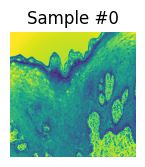

1 torch.Size([256, 256]) torch.Size([1])


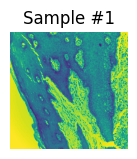

2 torch.Size([256, 256]) torch.Size([1])


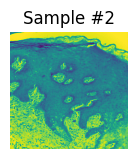

3 torch.Size([256, 256]) torch.Size([1])


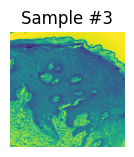

In [34]:
dataset = Oral_Can_Data(csv_file= '/home/iisers/Documents/oral_cancer_project/labels .csv',root_dir='/home/iisers/Documents/oral_cancer_project/Combined_data_resized')


fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['image'].shape, sample['can_type'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(sample['image'], sample['can_type'])

    if i == 3:
        plt.show()
        break

In [14]:
print(annotations)

NameError: name 'annotations' is not defined

In [28]:
torch.tensor(label).shape

torch.Size([])

In [15]:
root_dir ='/home/iisers/Documents/oral_cancer_project/Combined_data_resized'
csv_file = '/home/iisers/Documents/oral_cancer_project/labels .csv'
annotations = pd.read_csv(csv_file)
index = 1
#img_path = os.path.join(root_dir, annotations.iloc[index, 0])
img_name = annotations.iloc[index, 0] # selects the image name from the csv file
label = annotations.iloc[index, 1] # selects the label from the csv file
print(img_name, label)


Normal_100x_2.jpg 1


In [16]:
print(type(img_name))

<class 'str'>


In [17]:
img_path = os.path.join(root_dir, annotations.iloc[index, 0]) # path for accessing the image  # join: joins two strings

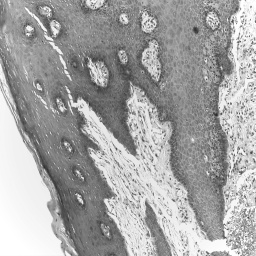

In [19]:
image = io.imread(img_path)
Image.fromarray(image)

In [23]:
image = np.array(image)


array([[131, 142, 152, ..., 247, 241, 255],
       [131, 125, 140, ..., 248, 253, 249],
       [150, 117, 138, ..., 254, 255, 255],
       ...,
       [255, 255, 255, ..., 186, 196, 219],
       [255, 255, 255, ..., 223, 195, 203],
       [253, 253, 253, ..., 190, 202, 216]], dtype=uint8)

In [26]:
image = torch.tensor(image)
image.shape

/tmp/ipykernel_98523/1179366887.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


torch.Size([256, 256])

In [24]:
index = torch.rand(1)
if torch.is_tensor(index):
    index = index.tolist()
print(index)

[0.7582082748413086]


In [22]:
index = torch.rand(2, 2)
if torch.is_tensor(index):
    index = index.tolist()
print(index)


[[0.8353351950645447, 0.1689949631690979], [0.8635521531105042, 0.6409557461738586]]


In [17]:
index = index.to_list()

AttributeError: 'list' object has no attribute 'to_list'

In [ ]:

train_set, validation_set = torch.utils.data.random_split(dataset,[20000,5000])
train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [6]:
batch_size = 10
num_workers = 4
pin_memory = True
# loading the dataset
dataset = Oral_Can_Data(csv_file= '/home/iisers/Documents/oral_cancer_project/labels .csv',root_dir='/home/iisers/Documents/oral_cancer_project/Combined_data_resized')

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set,  test_set = torch.utils.data.random_split(dataset, [train_size,val_size,test_size])

#dataflow = dict({'train' : train_set, 'valid': val_set , 'test' : test_set})
train_loader = DataLoader(dataset=train_set, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
validation_loader = DataLoader(dataset=val_set,  batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(dataset=test_set,  batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [9]:
for i in test_loader:
    print(i)

{'image': tensor([[[254, 254, 254,  ..., 249, 195, 178],
         [254, 254, 254,  ..., 255, 238, 185],
         [254, 254, 254,  ..., 254, 252, 216],
         ...,
         [254, 255, 255,  ..., 182, 175, 171],
         [252, 254, 255,  ..., 155, 123, 155],
         [255, 253, 252,  ..., 143, 189, 195]],

        [[255, 255, 255,  ..., 255, 255, 252],
         [255, 255, 255,  ..., 252, 253, 255],
         [255, 255, 255,  ..., 255, 255, 252],
         ...,
         [255, 255, 255,  ..., 247, 247, 249],
         [255, 255, 255,  ..., 251, 249, 247],
         [255, 255, 255,  ..., 247, 249, 249]],

        [[255, 255, 255,  ..., 255, 255, 254],
         [255, 255, 255,  ..., 255, 255, 254],
         [255, 255, 255,  ..., 255, 255, 254],
         ...,
         [ 82,  85,  93,  ..., 212, 202, 199],
         [ 80,  81,  88,  ..., 213, 203, 204],
         [ 81,  83,  80,  ..., 213, 199, 201]],

        ...,

        [[137, 137, 177,  ..., 113, 109, 143],
         [128, 152, 208,  ..., 164,

In [7]:
for x,y in enumerate(train_loader):
    print(x,y['can_type'])

/home/iisers/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


0 tensor([[2],
        [2],
        [2],
        [2],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1]])
1 tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])
2 tensor([[1],
        [2],
        [2],
        [2],
        [1],
        [2],
        [2],
        [2],
        [1],
        [2]])
3 tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])
4 tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [1],
        [2],
        [2],
        [2],
        [1]])
5 tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [1],
        [2]])
6 tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [1],
        [2],
        [2],
        [2],
        [2]])
7 tensor([[2],
        [1],
        [2],
        [2],
        [2],
  

In [40]:
for batch, data in enumerate(train_loader):
    print(batch, torch.max(data['can_type'], 1)[1])

    


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
torch.max(data['can_type'], 1)[1]

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(data['image'])
        #print(pred, pred.shape)
        #print(data['can_type'], data['can_type'].shape)
        #print(pred[0][0], data['can_type'][0][0])
        loss = loss_fn(pred, torch.max(data['can_type'], 1)[1])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(data['image'])
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            pred = model(data['image'])
            test_loss += loss_fn(pred, torch.max(data['can_type'], 1)[1]).item()
            correct += (pred.argmax(1) == torch.max(data['can_type'], 1)[1]).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = HybridModel().to(device)
model_without_qf = HybridModel_without_qf().to(device)
n_epochs = 5
#optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()


NameError: name 'learning_rate' is not defined

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
test_loop(test_loader, model, loss_fn)

In [17]:
d = torch.rand(10,2)
print(d[0][0].shape)

torch.Size([])


In [45]:
loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(n_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.673947  [   10/  369]


In [12]:
num_epochs = 10
learning_rate = 0.00001
train_CNN = False

pin_memory = True


In [31]:
for i in dataflow:
    print(i, len(dataflow[i]))

train 369
valid 79
test 80


In [ ]:
model = CNN().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for name, param in model.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN


In [36]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = HybridModel().to(device)
model_without_qf = HybridModel_without_qf().to(device)
n_epochs = 5
#optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()


In [17]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    return f"{float(num_correct)/float(num_samples)*100:.2f}"
        
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    model.train()

In [18]:
import tqdm

In [20]:
def train():
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        if epoch % 2 == 0:
            loop.set_postfix(val_acc = check_accuracy(validation_loader, model))
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())

if __name__ == "__main__":
    model.train()

In [37]:
accu_list1 = []
loss_list1 = []
accu_list2 = []
loss_list2 = []



def train(dataflow, model, device, optimizer):
    for i in range(2):
    #for feed_dict in dataflow['train']:
        #inputs = feed_dict['image'].to(device)
        #targets = feed_dict['can_type'].to(device)
        inputs = dataflow['train'][i]['image'].to(device)
        targets = dataflow['train'][i]['can_type'].to(device)
        #print(targets)
        #print(targets.shape)
        

        outputs = model(inputs)
        print(f'outputs: {outputs}')
        print(f'targets = {targets}')
        
        #print(outputs.shape)
        #print(outputs)

        #print(inputs)
        #loss = F.nll_loss(outputs, targets)
        loss = F.binary_cross_entropy(outputs[0][0].to(torch.float32), targets[0].to(torch.float32))
        #loss = criterion(outputs[0], targets.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')


def valid_test(dataflow, split, model, device, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():
        for i in range(2):
        #for feed_dict in dataflow[split]:
            #inputs = feed_dict['image'].to(device)
            #targets = feed_dict['can_type'].to(device)
            inputs = dataflow[split][i]['image'].to(device)
            targets = dataflow[split][i]['can_type'].to(device)

            outputs = model(inputs, use_qiskit=qiskit)

            target_all.append(targets.to(torch.float32))
            
            output_all.append(outputs[0][0].to(torch.float32))
            output_all = [torch.tensor(output_all)]
            
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)
        
    _, indices = output_all.topk(1, dim=1)
   
    masks = indices.eq(target_all.expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.binary_cross_entropy(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")

    return accuracy, loss

for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train(dataflow, model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid
    accu, loss = valid_test(dataflow, 'test', model, device, )
    accu_list1.append(accu)
    loss_list1.append(loss)
    scheduler.step()

Epoch 1:


RuntimeError: shape '[256, 256, 256]' is invalid for input of size 65536

In [40]:
accu_list1 = []
loss_list1 = []
accu_list2 = []
loss_list2 = []

def train(dataflow, model, device, optimizer):
    for feed_dict in train_loader:
        inputs = feed_dict['image'].to(device)
        targets = feed_dict['can_type'].to(device)
        #print(targets)
        #print(targets.shape)
        

        outputs = model(inputs)
        #print(outputs.shape)
        #print(outputs)

        #print(inputs)
        #loss = F.nll_loss(outputs, targets)
        loss = F.binary_cross_entropy(outputs[0][0].to(torch.float32), targets[0].to(torch.float32))
        #loss = criterion(outputs[0], targets.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')


def valid_test(dataflow, split, model, device, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict['image'].to(device)
            targets = feed_dict['can_type'].to(device)

            outputs = model(inputs, use_qiskit=qiskit)

            target_all.append(targets[0].to(torch.float32))
            output_all.append(outputs[0][0].to(torch.float32))
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.binary_cross_entropy(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")

    return accuracy, loss

for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train(dataflow, model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid
    accu, loss = valid_test(dataflow, 'test', model, device, )
    accu_list1.append(accu)
    loss_list1.append(loss)
    scheduler.step()


Epoch 1:


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.